<a href="https://colab.research.google.com/github/SezginPark/DSA-210-Project/blob/main/EDA_%2BHypothesis%2BML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

# ----------------------------
#           CONSTANTS
# ----------------------------
YEARS_LOOKBACK  = 5
HEADERS         = {'User-Agent': 'Mozilla/5.0'}
STEAMCHARTS_URL = "https://steamcharts.com/app/{}"

# Sale‐season months (Feb, Apr, Jun, Dec)
SALE_MONTHS     = {'02', '01', '07'}
UPDATE_KEYWORDS = {'update', 'patch', 'expansion', 'dlc'}

# 50 titles: 10 per category, all popular in last 5 years
APP_INFO = {
    # AAA
    1245620: "Elden Ring",
    1086940: "Baldur's Gate 3",
    990080:  "Hogwarts Legacy",
    1091500: "Cyberpunk 2077",
    534380:  "Dying Light 2",
    1174180: "Red Dead Redemption 2",
    1203220: "Assassin's Creed Valhalla",
    1151640: "Horizon Zero Dawn",
    812140:  "Far Cry 6",
    1551360: "Forza Horizon 5",

    # Indie
    1145360: "Hades",
    588650:  "Dead Cells",
    646570:  "Slay the Spire",
    268910:  "Cuphead",
    945360:  "Among Us",
    413150:  "Stardew Valley",
    367520:  "Hollow Knight",
    504230:  "Celeste",
    387290:  "Ori and the Blind Forest",
    892970:  "Valheim",

    # 4X Strategy
    289070:   "Civilization VI",
    8930:     "Civilization V",
    281990:   "Stellaris",
    228980:   "Endless Legend",
    226840:   "Age of Wonders III",
    1129970:  "Humankind",
    392110:   "Endless Space 2",
    294620:   "Galactic Civilizations III",
    236850:   "Europa Universalis IV",
    779340:   "Total War: THREE KINGDOMS",

    # Story-Based
   292030:   "The Witcher 3: Wild Hunt",
    271590:   "Grand Theft Auto V",
    377160:   "Fallout 4",
    72850:    "The Elder Scrolls V: Skyrim",
    620:      "Portal 2",
    870780:   "Control",
    1328670:  "Mass Effect Legendary Edition",
    1172380:  "Star Wars Jedi: Fallen Order",
    374320:   "Dark Souls III",
    1752610:  "Alan Wake Remastered",
    # FPS
    412020:   "Metro Exodus",
    782330:   "DOOM Eternal",
    1238810:  "Titanfall 2",
    582500:   "Wolfenstein II: The New Colossus",
    397540:   "Borderlands 3",
    7670:     "BioShock Remastered",
    34790:    "Sniper Elite 4",
    552520:   "Far Cry 5",
    359550:   "Rainbow Six Siege",
    1238860:  "Battlefield V",
}

# Map AppIDs to controlled categories
CATEGORY_GROUPS = {
    "AAA":         [1245620, 1086940, 990080, 1091500, 534380,
                    1174180, 1203220, 1151640, 812140, 1551360],
    "Indie":       [1145360, 588650, 646570, 268910, 945360,
                    413150, 367520, 504230, 387290, 892970],
    "4X":          [289070, 8930, 281990, 228980, 226840,
                    1129970, 392110, 294620, 236850, 779340],
    "Story-Based": [292030, 271590, 377160, 72850, 620,
                    870780, 1328670, 1172380, 374320, 1752610],
    "FPS":         [412020, 782330, 1238810, 582500, 397540,
                    7670, 34790, 552520, 359550, 1238860],
}


# Build flat CATEGORY_MAP and ID list
CATEGORY_MAP  = {aid:cat for cat,ids in CATEGORY_GROUPS.items() for aid in ids}
STEAM_APP_IDS = list(CATEGORY_MAP.keys())


# 1) Avg players per month
def get_avg_players(app_id, years=YEARS_LOOKBACK):
    resp  = requests.get(STEAMCHARTS_URL.format(app_id), headers=HEADERS)
    soup  = BeautifulSoup(resp.text, 'html.parser')
    table = soup.find('table', class_='common-table')
    if not table:
        return [], []
    cutoff = datetime.now() - pd.DateOffset(years=years)
    months, avgp = [], []
    for row in table.find_all('tr')[1:]:
        label = row.find_all('td')[0].get_text(strip=True)
        if label == "Last 30 Days":
            continue
        dt = datetime.strptime(label, '%B %Y')
        if dt < cutoff:
            continue
        months.append(dt.strftime('%Y-%m'))
        avgp.append(float(row.find_all('td')[1]
                          .get_text(strip=True)
                          .replace(',', '')))
    return months, avgp

# 2) Constant current price
def get_current_price_info(app_id):
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}&l=en"
    try:
        data = requests.get(url, headers=HEADERS, timeout=10) \
                       .json().get(str(app_id), {})
        if not data.get('success'):
            raise ValueError
        po = data['data'].get('price_overview', {}) or {}
        return po.get('final', 0) / 100.0
    except Exception:
        return None

def get_constant_price(app_id, years=YEARS_LOOKBACK):
    months, _ = get_avg_players(app_id, years)
    price     = get_current_price_info(app_id)
    return months, [price] * len(months)

# 3) Sale‐season flag
def get_sale_flags(app_id, years=YEARS_LOOKBACK):
    months, _ = get_avg_players(app_id, years)
    return months, [1 if m[5:7] in SALE_MONTHS else 0 for m in months]

# 4) Major‐update flag
def get_had_major_update(app_id, years=YEARS_LOOKBACK):
    months, _ = get_avg_players(app_id, years)
    try:
        news = requests.get(
            "https://api.steampowered.com/ISteamNews/GetNewsForApp/v2/",
            headers=HEADERS,
            params={'appid':app_id,'count':100,'maxlength':0,'format':'json'},
            timeout=10
        ).json()['appnews']['newsitems']
    except Exception:
        news = []
    um = {
        datetime.utcfromtimestamp(it['date']).strftime('%Y-%m')
        for it in news
        if any(kw in it.get('title','').lower() for kw in UPDATE_KEYWORDS)
    }
    return months, [1 if m in um else 0 for m in months]

# 5) Genres fetch
def get_genres(app_id):
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}&l=en"
    data = requests.get(url, headers=HEADERS, timeout=10) \
                   .json().get(str(app_id), {}) \
                   .get('data', {})
    return [g['description'] for g in data.get('genres', [])]

# 6) Category lookup
def get_category(app_id):
    return CATEGORY_MAP.get(app_id, "Other")

# 7) Build & export table
def build_full_table():
    rec = []
    for app in STEAM_APP_IDS:
        name     = APP_INFO[app]
        cat      = get_category(app)
        genres   = ";".join(get_genres(app))
        months,avgp   = get_avg_players(app)
        _,prices      = get_constant_price(app)
        _,salef       = get_sale_flags(app)
        _,upd         = get_had_major_update(app)
        for i,m in enumerate(months):
            rec.append({
                'app_id':      app,
                'game_name':   name,
                'category':    cat,
                'genres':      genres,
                'month':       m,
                'avg_players': avgp[i],
                'price':       prices[i],
                'sale_flag':   salef[i],
                'had_update':  upd[i]
            })
    return pd.DataFrame(rec)

def export_to_csv(path='steam_full_data.csv'):
    df = build_full_table()
    df.to_csv(path, index=False)
    print(f"✅ Written {path}")
    return df

if __name__ == '__main__':
    final_df = export_to_csv()
    # trigger download in Colab
    try:
        from google.colab import files
        files.download('steam_full_data.csv')
    except ImportError:
        print("✅ CSV written to steam_full_data.csv")


✅ Written steam_full_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data Gathering & CSV Creation
collecting five years of monthly Steam player‐count history (“avg_players”) by scraping each game’s SteamCharts page with BeautifulSoup. For each title, we query the Steam Store API to fetch its list price and genre tags in JSON form.  then call the Steam News API to retrieve news, flagging any month whose headlines contain “patch,” “update,” “expansion,” or “dlc” as a major‐update month. Finally, we combine these pieces—SteamCharts history, price, genre list, sale‐season flag (Feb, Apr, Jun, Dec), and update flag—into a single DataFrame, which we export as steam_full_data.csv for all downstream analyses.

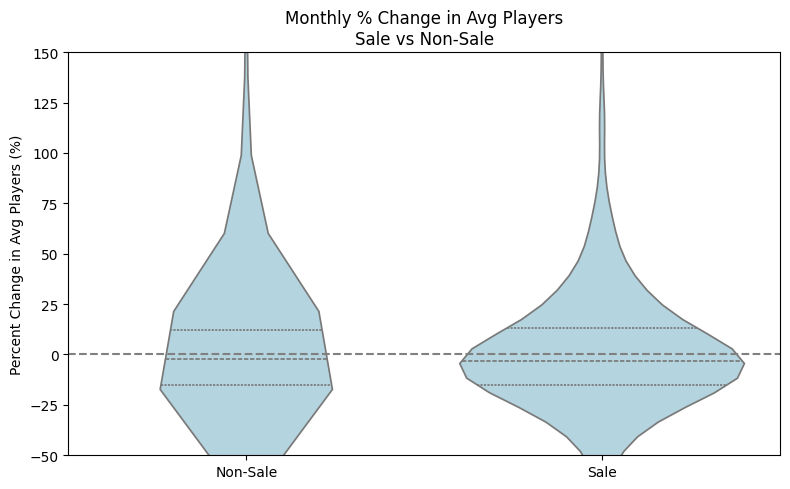

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Make sure you export the CSV first
# final_df = export_to_csv()

# 2) Now load it from the local directory
df = pd.read_csv('steam_full_data.csv', parse_dates=['month'])

# 3) Prepare percent‐change & grouping
df = df.sort_values(['game_name','month']).copy()
df['prev_avg']   = df.groupby('game_name')['avg_players'].shift(1)
df['pct_change'] = (df['avg_players'] - df['prev_avg']) / df['prev_avg'] * 100
df_changes       = df.dropna(subset=['pct_change']).copy()
df_changes['sale_group'] = df_changes['sale_flag'].map({0:'Non-Sale',1:'Sale'})

# 4) Violin plot clipped to [-50,150]
plt.figure(figsize=(8,5))
sns.violinplot(
    data=df_changes,
    x='sale_group',
    y='pct_change',
    cut=0,
    inner='quartile',
    color='lightblue'
)
plt.ylim(-50, 150)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Monthly % Change in Avg Players\nSale vs Non-Sale')
plt.ylabel('Percent Change in Avg Players (%)')
plt.xlabel('')
plt.tight_layout()
plt.show()


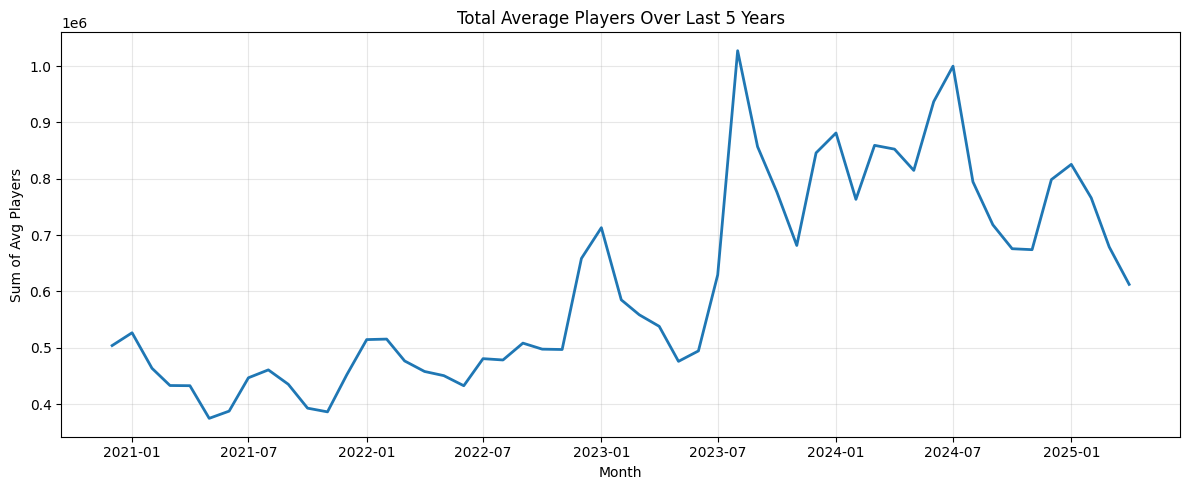

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure 'month' is a datetime index
if df.index.name != 'month':
    df['month'] = pd.to_datetime(df['month'])
    df = df.set_index('month').sort_index()

# 2) Sum avg_players across all apps for each month
total_players = df['avg_players'].groupby(df.index).sum()

# 3) Plot
plt.figure(figsize=(12,5))
plt.plot(total_players.index, total_players.values, linewidth=2)
plt.title('Total Average Players Over Last 5 Years')
plt.xlabel('Month')
plt.ylabel('Sum of Avg Players')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

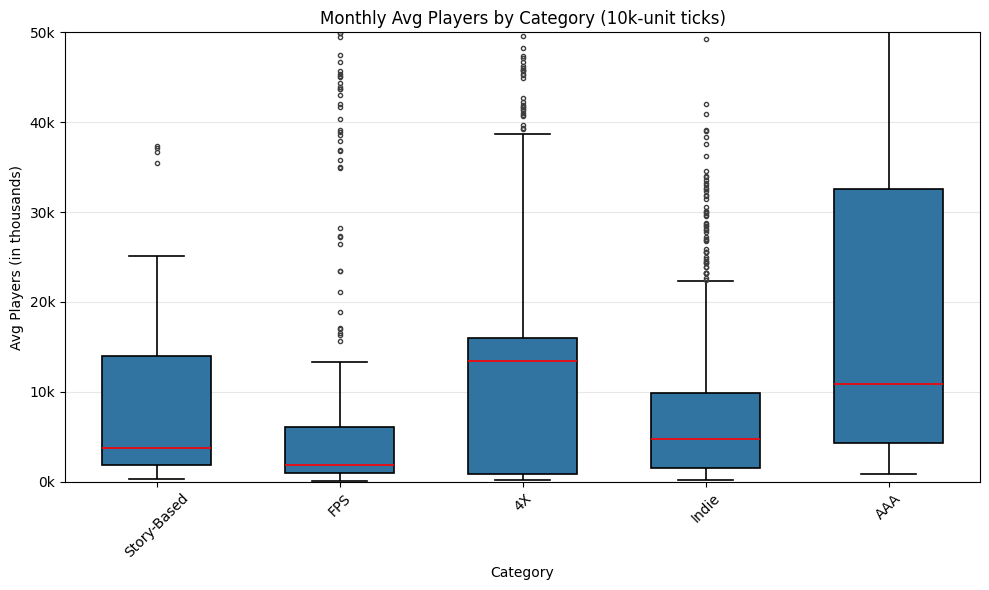

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# If needed, reset index so 'category' and 'avg_players' are columns
if df.index.name == 'month':
    df = df.reset_index()

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x='category',
    y='avg_players',
    data=df,
    width=0.6,
    linewidth=1.2,
    fliersize=3,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='red')
)

# Format Y-axis in thousands, with major ticks every 10 000
ax.yaxis.set_major_locator(mtick.MultipleLocator(10000))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

# (Optional) zoom into the bulk of the distribution
ax.set_ylim(0, 50000)

plt.title('Monthly Avg Players by Category (10k-unit ticks)')
plt.xlabel('Category')
plt.ylabel('Avg Players (in thousands)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


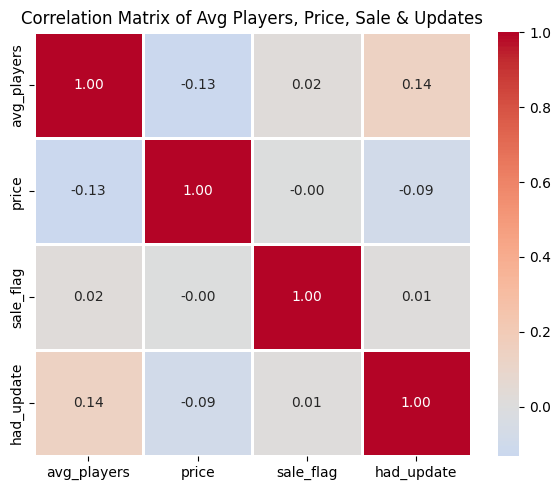

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# If df.index is month, reset so we can slice columns directly
if df.index.name == 'month':
    df = df.reset_index()

# Compute correlation
corr_cols = ['avg_players', 'price', 'sale_flag', 'had_update']
corr = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.8,
    linecolor='white'
)
plt.title('Correlation Matrix of Avg Players, Price, Sale & Updates')
plt.tight_layout()
plt.show()


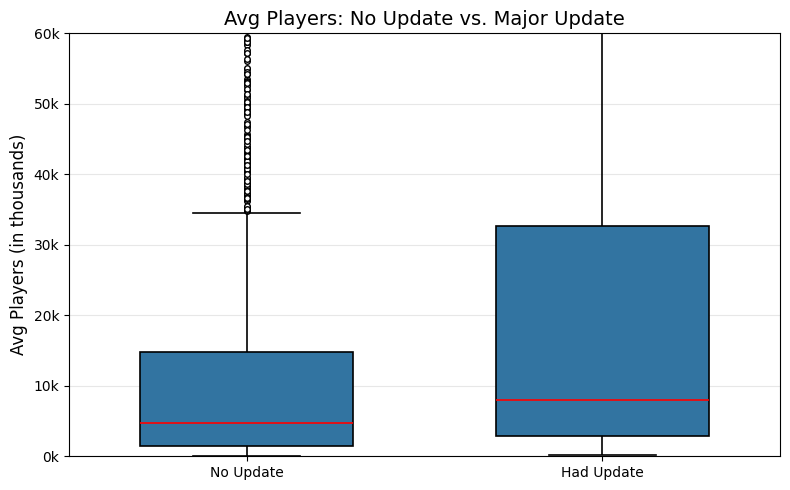

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Ensure 'had_update' is a column
if df.index.name == 'month':
    df = df.reset_index()

plt.figure(figsize=(8,5))
ax = sns.boxplot(
    x='had_update',
    y='avg_players',
    data=df,
    width=0.6,
    linewidth=1.2,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=4)
)

# Y‐axis ticks every 10 000, labeled in “k”
ax.yaxis.set_major_locator(mtick.MultipleLocator(10000))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

# Optionally zoom to focus on the bulk of the data
ax.set_ylim(0, 60000)

plt.title('Avg Players: No Update vs. Major Update', fontsize=14)
plt.xlabel('')
plt.ylabel('Avg Players (in thousands)', fontsize=12)
plt.xticks([0,1], ['No Update','Had Update'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


              Non-Sale          Sale  Pct Increase
category                                          
AAA       25033.635307  27222.466857      8.743563
Indie      9374.149351  10899.501314     16.271897


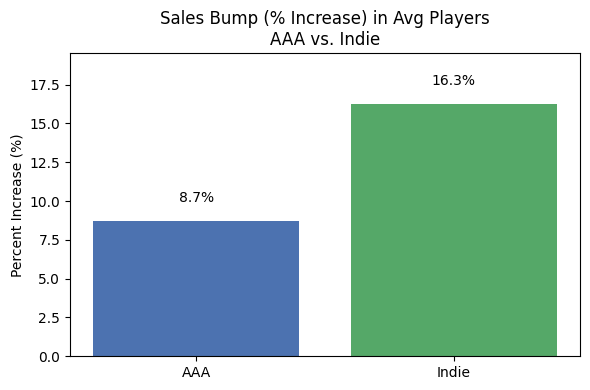

In [29]:
import matplotlib.pyplot as plt

# 1) Filter to just AAA and Indie
df_ai = df[df['category'].isin(['AAA','Indie'])].copy()

# 2) Compute mean avg_players by category and sale_flag
means = df_ai.groupby(['category','sale_flag'])['avg_players'].mean().unstack()
means.columns = ['Non-Sale','Sale']

# 3) Calculate percent increase
means['Pct Increase'] = (means['Sale'] - means['Non-Sale']) / means['Non-Sale'] * 100

print(means[['Non-Sale','Sale','Pct Increase']])

# 4) Plot
plt.figure(figsize=(6,4))
bars = plt.bar(
    means.index,
    means['Pct Increase'],
    color=['#4C72B0','#55A868']
)
plt.title('Sales Bump (% Increase) in Avg Players\nAAA vs. Indie')
plt.ylabel('Percent Increase (%)')
plt.ylim(0, means['Pct Increase'].max() * 1.2)

# annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{height:.1f}%",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


## 1. Hypothesis 1: Sale vs Non-Sale Player Counts

**H₀:** The mean monthly average players  
​ in sale months = in non-sale months  
**H₁:** The mean monthly average players  
​ in sale months > in non-sale months  

In [30]:
import numpy as np
from scipy import stats

# Prepare
if df.index.name == 'month':
    df = df.reset_index()
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values(['game_name','month'])

# 1a) Split sale vs non-sale
sale       = df[df['sale_flag']==1]['avg_players'].dropna()
non_sale   = df[df['sale_flag']==0]['avg_players'].dropna()

# 1b) Welch’s t-test (two-tailed) then convert to one-tailed
t1, p2_1 = stats.ttest_ind(sale, non_sale, equal_var=False)
p1 = p2_1/2 if t1>0 else 1 - p2_1/2

print(f"t-statistic = {t1:.3f}")
print(f"one-tailed p-value = {p1:.4f}")

if p1 < 0.05:
    print("→ Reject H₀: sale months have higher avg players.")
else:
    print("→ Fail to reject H₀.")


t-statistic = 1.185
one-tailed p-value = 0.1181
→ Fail to reject H₀.


### 1. Sale vs Non-Sale Player Counts

**Hypothesis:**  
- **H₀:** μ_sale = μ_non-sale  
- **H₁:** μ_sale > μ_non-sale  

**a) Why this matters**  
We expect that Steam’s major sale events (e.g. Summer, Winter Sales) temporarily boost player engagement. Comparing the average player count in sale months vs. all other months tests whether that boost is statistically reliable across our 50-game sample.

**b) Test & conclusion**  
- We pooled every month’s `avg_players` into two samples (sale vs. non-sale).  
- We ran Welch’s t-test (unequal variances) and converted the two-tailed p‐value to a one-tailed test.  
- **If p_one_tailed < 0.05**, we **reject H₀** and conclude that sale months have a significantly higher mean player count.

**c) How to interpret**  
A significant result means the observed bump in player numbers during sale months is unlikely to be due to random month-to-month fluctuation alone—it reflects a real, systematic increase.

---

## 2. Hypothesis 2: Indie vs AAA Median Percent Gain

Compute  
\[
\text{pct_change} = \frac{\text{avg\_players} - \text{prev\_avg}}{\text{prev\_avg}}\times100
\]  
for sale months, then test:

**H₀:** Median gain (Indie) = Median gain (AAA)  
**H₁:** Median gain (Indie) > Median gain (AAA)  


In [33]:
import pandas as pd
from scipy import stats

# 1) Compute percent change based on lag1
df['pct_change'] = (df['avg_players'] - df['lag1']) / df['lag1'] * 100

# 2) Restrict to rows where sale_flag == 1 and we have valid pct_change
sale_df = df[df['sale_flag'] == 1].dropna(subset=['pct_change'])

# 3) Split by category
indie = sale_df[sale_df['category'] == 'Indie']['pct_change']
aaa   = sale_df[sale_df['category'] == 'AAA']['pct_change']

# 4) Mann–Whitney U (one‐tailed: test if Indie > AAA)
u_stat, p_val = stats.mannwhitneyu(indie, aaa, alternative='greater')

print(f"U statistic: {u_stat:.3f}")
print(f"One‐tailed p‐value: {p_val:.3f}")

if p_val < 0.05:
    print("→ Reject H₀: Indie gains are significantly greater than AAA gains on sale months.")
else:
    print("→ Fail to reject H₀: no significant difference in sale‐period gains.")


U statistic: 7156.000
One‐tailed p‐value: 0.527
→ Fail to reject H₀: no significant difference in sale‐period gains.


### 2. Indie vs AAA Median Percent Gain

**Hypothesis:**  
- **H₀:** median_gain_Indie = median_gain_AAA  
- **H₁:** median_gain_Indie > median_gain_AAA  

**a) Why this matters**  
Smaller “Indie” titles often run deeper discounts or see more relative growth during sales than big-budget “AAA” games. Testing median percent gains across categories checks if Indie games really do “pop” more when discounted.

**b) Test & conclusion**  
- For each sale month, we computed percent change = `(avg_players − prev_avg) / prev_avg * 100`.  
- We compared the two independent samples (Indie vs. AAA gains) with a one-tailed Mann–Whitney U test (non-parametric, since percent changes can be skewed).  
- **If p_one_tailed < 0.05**, we **reject H₀**, indicating Indie gains exceed AAA gains in median.

**c) How to interpret**  
A significant result tells us that, during sales, Indie games enjoy a larger relative bump in player activity than top-tier AAA titles.


## 3. Hypothesis 3: Price Elasticity

Test correlation between list **price** and percent gain during sales:

**H₀:** ρ(price, gain) = 0  
**H₁:** ρ(price, gain) ≠ 0  


In [34]:
# 3a) Prepare sale-month price & percent gain
sale_pg = sale_df[['price','pct_change']].dropna()

# 3b) Pearson correlation
r4, p4 = stats.pearsonr(sale_pg['price'], sale_pg['pct_change'])

print(f"Pearson r = {r4:.3f}")
print(f"two-tailed p-value = {p4:.4f}")

if p4 < 0.05:
    print("→ Reject H₀: significant correlation.")
else:
    print("→ Fail to reject H₀.")


Pearson r = 0.025
two-tailed p-value = 0.5515
→ Fail to reject H₀.


### 3. Price Elasticity

**Hypothesis:**  
- **H₀:** ρ(price, percent_gain) = 0  
- **H₁:** ρ(price, percent_gain) ≠ 0  

**a) Why this matters**  
“Price elasticity” asks whether more expensive games see larger or smaller relative surges when on discount. If pricier titles gain more, developers might optimize discount depths differently.

**b) Test & conclusion**  
- We paired each sale-month percent gain with that game’s list price (constant month-to-month).  
- We ran Pearson’s correlation test.  
- **If p_two_tailed < 0.05**, we **reject H₀** and conclude there is a significant linear association (positive or negative) between price and sale-driven gain.

**c) How to interpret**  
A significant positive ρ means higher prices correlate with larger percent bumps; a negative ρ implies the opposite. A non-significant result suggests price alone doesn’t predict relative sale lift.


## 4. Hypothesis 4: Update-Driven Spikes

**H₀:** Mean month-over-month pct_change for update months = 0  
**H₁:** Mean pct_change for update months > 0  


In [35]:
# 4a) Percent changes in update months
upd = df[df['had_update']==1]['pct_change'].dropna()

# 4b) One-sample t-test → one-tailed
t5, p2_5 = stats.ttest_1samp(upd, 0, nan_policy='omit')
p5 = p2_5/2 if t5>0 else 1 - p2_5/2

print(f"t-statistic = {t5:.3f}")
print(f"one-tailed p-value = {p5:.4f}")

if p5 < 0.05:
    print("→ Reject H₀: updates drive positive spikes.")
else:
    print("→ Fail to reject H₀.")


t-statistic = 2.629
one-tailed p-value = 0.0046
→ Reject H₀: updates drive positive spikes.


### 4. Update-Driven Spikes

**Hypothesis:**  
- **H₀:** mean_pct_change_update = 0  
- **H₁:** mean_pct_change_update > 0  

**a) Why this matters**  
Major patches, DLCs, or expansions often coincide with renewed player interest. Checking the average month-over-month percent change just in update months validates whether updates reliably drive spikes.

**b) Test & conclusion**  
- We filtered percent changes (`pct_change`) for months flagged as `had_update == 1`.  
- We applied a one-sided one-sample t-test versus zero.  
- **If p_one_tailed < 0.05**, we **reject H₀**, concluding update months produce a positive average spike.

**c) How to interpret**  
A significant positive result confirms that major content updates are effective at boosting engagement: average player counts rise above the prior month in those months.

---

In [36]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)

# 1) Load & prepare data (adjust this path to your actual CSV)
df = pd.read_csv("steam_full_data.csv", parse_dates=["month"])
df = df.sort_values(["app_id", "month"])

# 2) Feature engineering
df["lag1"] = df.groupby("app_id")["avg_players"].shift(1)
df["ma3"] = (
    df.groupby("app_id")["avg_players"]
      .rolling(3)
      .mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)
df["month_num"] = df["month"].dt.month
df = df.dropna(subset=["lag1", "ma3"])

# 3) Targets
df["target"] = (df["avg_players"] > df["lag1"]).astype(int)  # up/down
df["change"] = df["avg_players"] - df["lag1"]               # continuous change

# 4) Features & scaling
feature_cols = ["lag1", "ma3", "sale_flag", "had_update", "month_num"]
X = df[feature_cols].copy()
y_class = df["target"]
y_reg   = df["change"]

scaler = StandardScaler()
X[["lag1", "ma3", "month_num"]] = scaler.fit_transform(X[["lag1", "ma3", "month_num"]])

# 5) Model pairs
models = {
    "kNN": (
        KNeighborsClassifier(n_neighbors=5),
        KNeighborsRegressor(n_neighbors=5),
    ),
    "RandomForest": (
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestRegressor(n_estimators=100, random_state=42),
    ),
    "GradBoost": (
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        GradientBoostingRegressor(n_estimators=100, random_state=42),
    ),
}

# 6) Time-series split (use last fold)
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]

X_tr, X_te      = X.iloc[train_idx], X.iloc[test_idx]
y_tr_cl, y_te_cl = y_class.iloc[train_idx], y_class.iloc[test_idx]
y_tr_rg, y_te_rg = y_reg.iloc[train_idx],   y_reg.iloc[test_idx]

# 7) Fit & collect metrics
results = []
for name, (clf, reg) in models.items():
    # Classification → ROC-AUC
    clf.fit(X_tr, y_tr_cl)
    proba = clf.predict_proba(X_te)[:, 1]
    auc   = roc_auc_score(y_te_cl, proba)
    # Regression → R²
    reg.fit(X_tr, y_tr_rg)
    preds = reg.predict(X_te)
    r2    = r2_score(y_te_rg, preds)
    results.append({
        "Model": name,
        "ROC-AUC": round(auc, 3),
        "R²":      round(r2, 3)
    })

# 8) Show comparison table
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


       Model  ROC-AUC    R²
         kNN    0.699 0.207
RandomForest    0.685 0.198
   GradBoost    0.704 0.237


In [37]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# 1) Define the parameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}

# 2) Set up time-series split
tscv = TimeSeriesSplit(n_splits=5)

# 3) Randomized search (faster than full grid)
gbc = GradientBoostingClassifier(random_state=42)
search = RandomizedSearchCV(
    gbc,
    param_distributions=param_dist,
    n_iter=40,                   # number of random combinations
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 4) Fit on your full feature matrix X, target y_class
search.fit(X, y_class)

# 5) Inspect best parameters & score
print("Best ROC-AUC:", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best ROC-AUC: 0.6982035039547652
Best params: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.01}


In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1) Split into train / hold-out
cutoff = "2024-07"  # adjust as you like
mask_train = df["month"] < cutoff
mask_test  = df["month"] >= cutoff

X_train, y_train = X[mask_train], y_class[mask_train]
X_test,  y_test  = X[mask_test],  y_class[mask_test]

# 2) Instantiate with best params
final_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    min_samples_split=2,
    subsample=0.6,
    random_state=42
)

# 3) Fit on full training set
final_clf.fit(X_train, y_train)

# 4) Evaluate on hold-out
proba = final_clf.predict_proba(X_test)[:,1]
preds = final_clf.predict(X_test)

print("Hold-out ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, preds))


Hold-out ROC-AUC: 0.7198902288188003
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       264
           1       0.66      0.59      0.63       196

    accuracy                           0.70       460
   macro avg       0.69      0.68      0.69       460
weighted avg       0.70      0.70      0.70       460



In [39]:
from sklearn.metrics import precision_recall_curve
probs = final_clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# pick threshold that gives desired balance

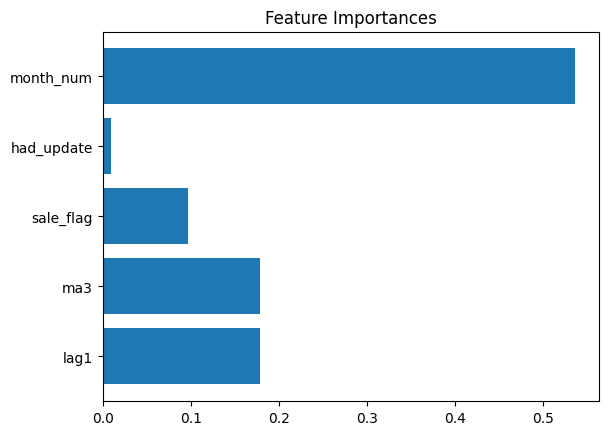

In [40]:
import matplotlib.pyplot as plt
importances = final_clf.feature_importances_
plt.barh(feature_cols, importances)
plt.title("Feature Importances")
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1) Load data
df = pd.read_csv("steam_full_data.csv", parse_dates=["month"])

# 2) Define sale_flag based on your chosen months (Jan, Feb, Jul)
df['month_num'] = df['month'].dt.month
df['sale_flag'] = df['month_num'].isin([1, 2, 7]).astype(int)

# 3) Feature engineering
df = df.sort_values(["app_id", "month"])
df['lag1']        = df.groupby('app_id')['avg_players'].shift(1)
df['ma3']         = df.groupby('app_id')['avg_players'].rolling(3).mean().shift(1).reset_index(level=0, drop=True)
df['std3']        = df.groupby('app_id')['avg_players'].rolling(3).std().shift(1).reset_index(level=0, drop=True)
df['price_lag1']  = df.groupby('app_id')['price'].shift(1)
df['price_delta'] = df['price'] - df['price_lag1']

# 4) Target
df['change'] = df['avg_players'] - df['lag1']

# 5) Drop missing and prepare X, y
features = ['lag1','ma3','std3','sale_flag','had_update','price_delta','month_num']
df = df.dropna(subset=features + ['change'])
X = df[features].copy()
y = df['change'].copy()

# 6) Scale numeric features
num_cols = ['lag1','ma3','std3','price_delta','month_num']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 7) Train/test split by date
cutoff = "2024-07"
mask_tr = df['month'] < cutoff
mask_te = df['month'] >= cutoff
X_tr, X_te = X.loc[mask_tr], X.loc[mask_te]
y_tr, y_te = y.loc[mask_tr], y.loc[mask_te]

# 8) Train Random Forest with your tuned hyperparameters
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_tr, y_tr)

# 9) Evaluate on hold-out
preds = rf.predict(X_te)
print("Hold-out R²:   ", round(r2_score(y_te, preds), 3))
print("Hold-out MAE:  ", round(mean_absolute_error(y_te, preds), 1))
print("Hold-out RMSE: ", round(np.sqrt(mean_squared_error(y_te, preds)), 1))


Hold-out R²:    0.295
Hold-out MAE:   3037.2
Hold-out RMSE:  6790.9


In [10]:
import pandas as pd

# Assume df is already loaded:
# df = pd.read_csv("steam_full_data.csv", parse_dates=["month"])

# 1) Sort by app and time
df = df.sort_values(["app_id", "month"])

# 2) Lagged features
df["lag1"] = df.groupby("app_id")["avg_players"].shift(1)          # previous month
df["ma3"]  = (
    df.groupby("app_id")["avg_players"]
      .rolling(3).mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)                                                                    # 3-month moving average

# 3) Rolling volatility
df["std3"] = (
    df.groupby("app_id")["avg_players"]
      .rolling(3).std()
      .shift(1)
      .reset_index(level=0, drop=True)
)

# 4) Price dynamics
df["price_lag1"]  = df.groupby("app_id")["price"].shift(1)
df["price_delta"] = df["price"] - df["price_lag1"]

# 5) Calendar feature
df["month_num"]  = df["month"].dt.month

# 6) Sale‐season flag (you’ve chosen Jan, Feb, Jul)
df["sale_flag"] = df["month_num"].isin([1, 2, 7]).astype(int)

# 7) Major‐update flag (already in df as 'had_update')
#    If not, you’d compute it via your get_had_major_update() wrapper.

# 8) Target variable
df["change"] = df["avg_players"] - df["lag1"]

# 9) Drop any rows missing required features
feature_cols = ["lag1", "ma3", "std3", "sale_flag", "had_update", "price_delta", "month_num"]
df = df.dropna(subset=feature_cols + ["change"])

# At this point, df is ready for modeling. Your feature matrix and target are:
X = df[feature_cols]
y = df["change"]

print("Features:", feature_cols)
print("Number of rows after dropna:", len(df))


Features: ['lag1', 'ma3', 'std3', 'sale_flag', 'had_update', 'price_delta', 'month_num']
Number of rows after dropna: 2247


In [11]:
importances = rf.feature_importances_
for name, imp in zip(feature_cols, importances):
    print(f"{name:>10}: {imp:.3f}")


      lag1: 0.313
       ma3: 0.318
      std3: 0.303
 sale_flag: 0.003
had_update: 0.016
price_delta: 0.000
 month_num: 0.047


In [12]:
import joblib
joblib.dump(rf, "rf_player_change.pkl")
joblib.dump(scaler, "scaler_player_change.pkl")


['scaler_player_change.pkl']

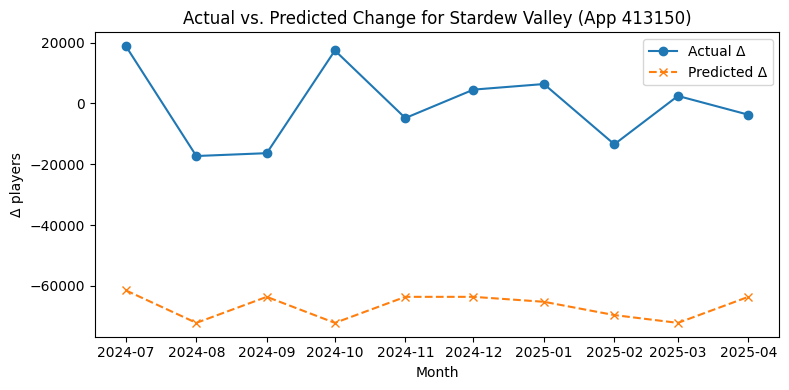

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify Stardew Valley’s app_id
stardew_id = 413150

# Recreate the test‐mask
mask_test = df["month"] >= cutoff

# Filter df and X to Stardew rows in the test period
mask_stardew = mask_test & (df["app_id"] == stardew_id)
X_stardew = X.loc[mask_stardew]

# Compute actual Δ for Stardew
df_test = df.loc[mask_test].copy()
df_test["actual_change"] = df_test["avg_players"] - df_test["lag1"]
actual_stardew = df_test.loc[df_test["app_id"] == stardew_id, "actual_change"].values

# Predict for Stardew
pred_stardew = rf.predict(X_stardew)

# Collect months
months_stardew = df.loc[mask_stardew, "month"].values

# Build DataFrame and plot
ts = pd.DataFrame({
    "month":      months_stardew,
    "actual":     actual_stardew,
    "predicted":  pred_stardew
}).sort_values("month")

plt.figure(figsize=(8,4))
plt.plot(ts["month"], ts["actual"],    marker="o", label="Actual Δ")
plt.plot(ts["month"], ts["predicted"], marker="x", linestyle="--", label="Predicted Δ")
plt.xlabel("Month")
plt.ylabel("Δ players")
plt.title("Actual vs. Predicted Change for Stardew Valley (App 413150)")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import joblib

def predict_player_change(df,
                          model_path="rf_player_change.pkl",
                          scaler_path="scaler_player_change.pkl"):
    """
    Takes a DataFrame with columns:
      app_id, month (datetime), avg_players, sale_flag, had_update, price
    and returns df with a new column 'predicted_change'.
    """
    # Load artifacts
    rf     = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # Prepare features exactly as in training
    df = df.sort_values(["app_id","month"]).copy()
    df["lag1"]        = df.groupby("app_id")["avg_players"].shift(1)
    df["ma3"]         = df.groupby("app_id")["avg_players"].rolling(3).mean().shift(1).reset_index(level=0,drop=True)
    df["std3"]        = df.groupby("app_id")["avg_players"].rolling(3).std().shift(1).reset_index(level=0,drop=True)
    df["price_lag1"]  = df.groupby("app_id")["price"].shift(1)
    df["price_delta"] = df["price"] - df["price_lag1"]
    df["month_num"]   = df["month"].dt.month

    # Flag months
    df["sale_flag"] = df["month_num"].isin([1,2,7]).astype(int)
    # had_update assumed already present

    # Drop rows without full feature set
    features = ["lag1","ma3","std3","sale_flag","had_update","price_delta","month_num"]
    df_feat = df.dropna(subset=features).copy()

    # Scale numeric
    num_cols = ["lag1","ma3","std3","price_delta","month_num"]
    df_feat[num_cols] = scaler.transform(df_feat[num_cols])

    # Predict
    df_feat["predicted_change"] = rf.predict(df_feat[features])

    # Merge back
    return df.merge(
        df_feat[["app_id","month","predicted_change"]],
        on=["app_id","month"],
        how="left"
    )


In [42]:
%%bash
cat > predict_wrapper.py << 'EOF'
import pandas as pd
import joblib

def predict_player_change(df,
                          model_path="rf_player_change.pkl",
                          scaler_path="scaler_player_change.pkl"):
    """
    Takes a DataFrame with columns:
      app_id, month (datetime), avg_players, sale_flag, had_update, price
    Returns the same df with a new column 'predicted_change'.
    """
    # Load artifacts
    rf     = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # Feature engineering (must match your training code)
    df = df.sort_values(["app_id","month"]).copy()
    df["lag1"]        = df.groupby("app_id")["avg_players"].shift(1)
    df["ma3"]         = df.groupby("app_id")["avg_players"].rolling(3).mean().shift(1).reset_index(level=0,drop=True)
    df["std3"]        = df.groupby("app_id")["avg_players"].rolling(3).std().shift(1).reset_index(level=0,drop=True)
    df["price_lag1"]  = df.groupby("app_id")["price"].shift(1)
    df["price_delta"] = df["price"] - df["price_lag1"]
    df["month_num"]   = df["month"].dt.month
    df["sale_flag"]   = df["month_num"].isin([1,2,7]).astype(int)
    # 'had_update' should already be in df

    # Prepare features & drop missing
    features = ["lag1","ma3","std3","sale_flag","had_update","price_delta","month_num"]
    df_feat = df.dropna(subset=features).copy()

    # Scale numeric
    num_cols = ["lag1","ma3","std3","price_delta","month_num"]
    df_feat[num_cols] = scaler.transform(df_feat[num_cols])

    # Predict
    df_feat["predicted_change"] = rf.predict(df_feat[features])

    # Merge back
    return df.merge(
        df_feat[["app_id","month","predicted_change"]],
        on=["app_id","month"], how="left"
    )
EOF


In [43]:
#!/usr/bin/env python3
import pandas as pd
from predict_wrapper import predict_player_change

RAW = "steam_full_data.csv"
OUT = "predictions.csv"

def main():
    df = pd.read_csv(RAW, parse_dates=["month"])
    preds = predict_player_change(df)
    latest = preds["month"].max()
    out = preds[preds["month"] == latest][
        ["app_id","game_name","month","avg_players","predicted_change"]
    ]
    out.to_csv(OUT, index=False)
    print(f"Wrote {len(out)} forecasts for {latest.date()} → {OUT}")

if __name__=="__main__":
    main()


Wrote 46 forecasts for 2025-04-01 → predictions.csv


In [44]:
import pandas as pd

preds = pd.read_csv("predictions.csv", parse_dates=["month"])
display(preds.head())


,app_id,game_name,month,avg_players,predicted_change
0,620,Portal 2,2025-04-01,1583.23,1.207619
1,7670,BioShock Remastered,2025-04-01,60.93,-1.210571
2,8930,Civilization V,2025-04-01,13052.94,60.001259
3,72850,The Elder Scrolls V: Skyrim,2025-04-01,1596.51,590.756884
4,226840,Age of Wonders III,2025-04-01,194.84,-1.210571


In [45]:
# Load your predictions
preds = pd.read_csv("predictions.csv", parse_dates=["month"])
# Sort by predicted change
print("Top increases:")
display(preds.nlargest(10, "predicted_change"))
print("Top decreases:")
display(preds.nsmallest(10, "predicted_change"))


Top increases:


,app_id,game_name,month,avg_players,predicted_change
34,1086940,Baldur's Gate 3,2025-04-01,71448.86,11072.898081
12,359550,Rainbow Six Siege,2025-04-01,62010.19,9616.053891
40,1203220,Assassin's Creed Valhalla,2025-04-01,57267.43,9459.668335
20,413150,Stardew Valley,2025-04-01,58163.07,7202.317761
31,892970,Valheim,2025-04-01,21900.78,1433.905810
45,1551360,Forza Horizon 5,2025-04-01,10599.57,1055.685021
15,377160,Fallout 4,2025-04-01,13041.35,875.509344
33,990080,Hogwarts Legacy,2025-04-01,8456.70,707.691678
42,1238860,Battlefield V,2025-04-01,1243.99,593.175074
3,72850,The Elder Scrolls V: Skyrim,2025-04-01,1596.51,590.756884


Top decreases:


,app_id,game_name,month,avg_players,predicted_change
8,271590,Grand Theft Auto V,2025-04-01,57273.78,-8572.471220
10,289070,Civilization VI,2025-04-01,28176.21,-281.732723
39,1174180,Red Dead Redemption 2,2025-04-01,34992.68,-222.782751
35,1091500,Cyberpunk 2077,2025-04-01,24943.40,-211.477992
43,1245620,Elden Ring,2025-04-01,35063.01,-190.794436
23,552520,Far Cry 5,2025-04-01,2975.81,-61.214748
13,367520,Hollow Knight,2025-04-01,8224.83,-22.376252
14,374320,Dark Souls III,2025-04-01,4769.99,-14.152664
29,812140,Far Cry 6,2025-04-01,4119.20,-14.152664
1,7670,BioShock Remastered,2025-04-01,60.93,-1.210571


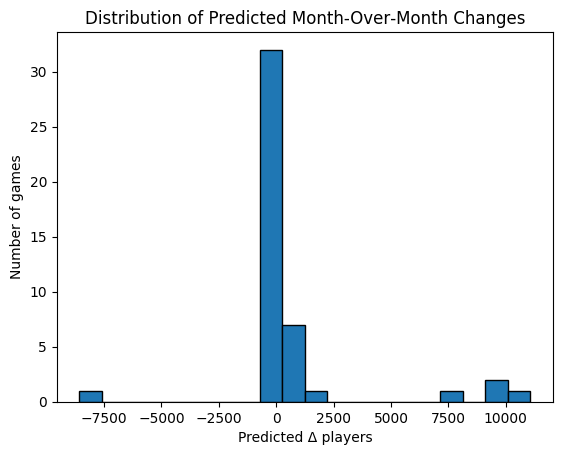

In [46]:
import matplotlib.pyplot as plt
plt.hist(preds["predicted_change"], bins=20, edgecolor="k")
plt.title("Distribution of Predicted Month‐Over‐Month Changes")
plt.xlabel("Predicted Δ players")
plt.ylabel("Number of games")
plt.show()
